In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'storage'
label_csv = f'storage/train.csv'
n = len(list(open(label_csv)))-1

In [4]:
labels = list(map(str, pd.read_csv(label_csv)['Target']))
labels = [[int(ll) for ll in l.split()] for l in labels]
ohlabels = np.zeros((n, 28))
for i, labs in enumerate(labels):
    for c in labs:        
        ohlabels[i, int(c)] = 1.0

In [5]:
FOLD_NUM = 0

In [6]:
# https://github.com/trent-b/iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
stratified = list(msss.split(np.arange(n), ohlabels))
trn_idxs = np.array(list(stratified[FOLD_NUM][0]))
val_idxs = np.array(list(stratified[FOLD_NUM][1]))

In [7]:
len(stratified[0][0]), len(stratified[0][1]), len(labels), len(stratified[0][0])+len(stratified[0][1])

(88452, 22019, 110471, 110471)

In [8]:
labels_num_flat = [item for sublist in np.array(labels)[trn_idxs] for item in sublist]
label_counts = dict((x,labels_num_flat.count(x)/len(trn_idxs)) for x in range(28)) # 
print('trn label props',label_counts)
labels_num_flat = [item for sublist in np.array(labels)[val_idxs] for item in sublist]
label_counts = dict((x,labels_num_flat.count(x)/len(val_idxs)) for x in set(labels_num_flat)) # 
print('val label props',label_counts)

trn label props {0: 0.37771898883009997, 1: 0.0277890833446389, 2: 0.10290326956993624, 3: 0.030988558766336546, 4: 0.04681635237190793, 5: 0.05566861122416678, 6: 0.03504725726947949, 7: 0.08594491927825261, 8: 0.009813232035454257, 9: 0.008908786686564465, 10: 0.00823045267489712, 11: 0.02020304798082576, 12: 0.021231854565187898, 13: 0.013182290960068737, 14: 0.025324469768914212, 15: 0.011396011396011397, 16: 0.015612987835210057, 17: 0.008072174738841406, 18: 0.01824718491385158, 19: 0.033928006150228375, 20: 0.007925202369646814, 21: 0.12874779541446207, 22: 0.025754081309636866, 23: 0.09443539999095554, 24: 0.0077443132998688555, 25: 0.3471826527382083, 26: 0.006387645276534165, 27: 0.005743227965450188}
val label props {0: 0.3793541941050911, 1: 0.027930423724964803, 2: 0.10336527544393478, 3: 0.031109496344066487, 4: 0.047004859439574914, 5: 0.05590626277305963, 6: 0.03519687542576865, 7: 0.08628911394704573, 8: 0.009855125119215224, 9: 0.008946818656614742, 10: 0.008265588809

In [9]:
f_model = resnext50

In [10]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with 3rd weights
        w = layers[0].weight.data
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        #layers[0].weight = torch.nn.Parameter(torch.cat((w,w[2]),dim=1)) # my attempt...
        layers[0].weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1)) # copied from kaggle post        
        #layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))  
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss    
    
    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [11]:
import os
def open_multichannel_image(path, id, colours):    
    flags = cv2.IMREAD_GRAYSCALE    
    img = [cv2.imread(os.path.join(path, id[:-4] + '_' + colour + '.png'), flags) for colour in colours]    
    sz = 512    
    try:
        img = [im.astype(np.float32)/255 for im in img]
    except:
        print('hi1', path+id)
    try:
        stacked = np.stack(img, axis=-1)
    except:
        print('hi2', path+id)
        print(img)
    return stacked

channel_names = ['red', 'green', 'blue', 'yellow']

def get_x_multichannel(self, i):
    #print(self.fnames)
    #a
    img = open_multichannel_image(self.path, self.fnames[i], channel_names)
    if self.sz == 512: return img # change to match your image dimensions
    else: return cv2.resize(img, (self.sz, self.sz), cv2.INTER_AREA) 

# monkey patching, must be done before new class is defined and had to be this specific class
FilesNhotArrayDataset.get_x = get_x_multichannel
    
class MultichannelImageClassifierData(ImageData):
    def set_weighted_dls(self):                
        self.trn_dl = DataLoader(self.trn_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers, pin_memory=False, sampler=trn_weighted_sampler)
        #self.val_dl = DataLoader(self.val_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers, pin_memory=False, sampler=val_weighted_sampler)
    
    @classmethod
    def from_csv(cls, path, folder, csv_fname, channel_names=channel_names, bs=64, tfms=(None,None),
               val_idxs=None, suffix='', channel_sep='_', test_name=None, continuous=False, skip_header=True, num_workers=8, cat_separator=' '):
        assert not (tfms[0] is None or tfms[1] is None), "please provide transformations for your train and validation sets"
        assert not (os.path.isabs(folder)), "folder needs to be a relative path"
        fnames,y,classes = csv_source(folder, csv_fname, skip_header, suffix, continuous=continuous)                      
        
        # from_names_and_array
        val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
        ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)        
            
        test_ids = pd.read_csv('storage/sample_submission.csv', index_col=0, header=0)        
        
        test_fnames = []
        for i in range(len(test_ids)):
            test_fnames.append(test_name + '/' + test_ids.index[i] + suffix)                                            
            
        f = FilesNhotArrayDataset # multiple classes per label            
        datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                               path=path, test=test_fnames)
        return cls(path, datasets, bs, num_workers, classes=classes)

def get_data(sz, bs):
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.06734, 0.05087, 0.03266, 0.09257],[0.11997, 0.10335, 0.10124, 0.1574])
    #stats = A([0.08069, 0.05258, 0.05487] #, 0.08282]
    #          , [0.13704, 0.10145, 0.15313]) #, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    md = MultichannelImageClassifierData.from_csv(PATH, 'train', label_csv, bs=bs, tfms=tfms,
                    suffix='.png', val_idxs=val_idxs, test_name='test')      
    return md

In [12]:
sz=64
bs=64

In [13]:
data = get_data(sz, bs)

In [14]:
from sklearn.metrics import fbeta_score
def f1_macro(preds, targs, start=0.0, end=0.99, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 1, average='macro')
                    for th in np.arange(start,end,step)])
learn = ConvLearner.pretrained(f_model, data, metrics=[f1_macro])
learn.opt_fn = optim.Adam

In [15]:
learn.model

Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      (0): LambdaMap(
        (0): Sequential(
          (0): Sequential(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
            (2): ReLU()
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
            (5): ReLU()
          )
          (1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): Sequential(
          (0): Conv2d(64, 256, kernel

 73%|███████▎  | 1014/1383 [07:57<02:53,  2.13it/s, loss=0.675]

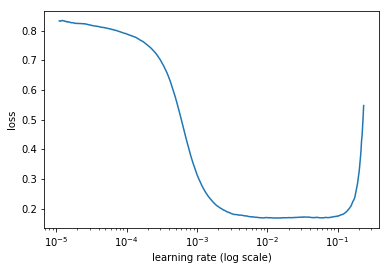

In [16]:
lrf=learn.lr_find()
learn.sched.plot()

In [15]:
lr = 0.00075
lrs = np.array([lr/9,lr/3,lr])
learn.freeze()

In [16]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f1_macro   
    0      0.162111   0.154103   0.11718   
    1      0.156058   0.152184   0.123266  
    2      0.152983   0.1512     0.125992  
    3      0.152185   0.15142    0.125404  
    4      0.153138   0.150391   0.129162  
    5      0.152564   0.149585   0.130112  
    6      0.151545   0.149317   0.131042  



[array([0.14932]), 0.13104163987944192]

In [17]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}')

epoch      trn_loss   val_loss   f1_macro   
    0      0.140558   0.138118   0.156588  
    1      0.136513   0.132562   0.177857  
    2      0.131745   0.127712   0.192168  
    3      0.13013    0.128037   0.194062  
    4      0.126298   0.123446   0.210164  
    5      0.120442   0.119569   0.221651  
    6      0.117493   0.118305   0.224726  



In [18]:
sz=128

In [19]:
data = get_data(sz, bs)
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f1_macro   
    0      0.123878   0.119901   0.23438   
    1      0.119553   0.118429   0.240039  
    2      0.117273   0.117831   0.239714  
    3      0.119003   0.117452   0.240255  
    4      0.120319   0.116941   0.241498  
    5      0.118903   0.116674   0.24341   
    6      0.118445   0.116108   0.245204  



[array([0.11611]), 0.24520449593146432]

In [20]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}')

epoch      trn_loss   val_loss   f1_macro   
    0      0.112364   0.104042   0.282936  
    1      0.105913   0.103919   0.283544  
    2      0.09932    0.097532   0.304292  
    3      0.104012   0.103449   0.292556  
    4      0.095868   0.096814   0.309969  
    5      0.092647   0.091957   0.325162  
    6      0.089339   0.090769   0.327495  



In [21]:
sz=256

In [22]:
data = get_data(sz, bs)
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_frozen')

epoch      trn_loss   val_loss   f1_macro   
    0      0.100935   0.097703   0.312515  
    1      0.096504   0.095585   0.317714  
    2      0.095525   0.094753   0.317897  
    3      0.095478   0.094033   0.321911  
    4      0.095079   0.09318    0.322996  
    5      0.093125   0.09267    0.326737  
    6      0.091165   0.092689   0.326104  



In [18]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}')

epoch      trn_loss   val_loss   f1_macro   
    0      0.082292   0.08124    0.361232  
    1      0.083728   0.081818   0.362819  
    2      0.07508    0.07753    0.375586  
    3      0.081399   0.082433   0.36049   
    4      0.076355   0.078184   0.374366  
    5      0.069544   0.074726   0.388429  
    6      0.062191   0.074713   0.386072  



In [15]:
sz=512

In [16]:
lr = 0.00075
lrs = np.array([lr/6,lr/3,lr])

In [20]:
data = get_data(sz, bs)
learn.set_data(data)
learn.freeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_frozen')

epoch      trn_loss   val_loss   f1_macro   
    0      0.093709   0.095382   0.328231  
    1      0.091559   0.091797   0.335949  
    2      0.092162   0.091331   0.336966  



In [21]:
learn.fit(lr, 1, cycle_len=3, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_frozen_1')

epoch      trn_loss   val_loss   f1_macro   
    0      0.088621   0.09014    0.33857   
    1      0.087534   0.089007   0.342843  
    2      0.089799   0.088767   0.342419  



In [17]:
bs = 16
data = get_data(sz, bs)
learn.set_data(data)
learn.unfreeze()

In [23]:
learn.fit(lrs, 1, cycle_len=1, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_1') # 

epoch      trn_loss   val_loss   f1_macro   
    0      0.0851     0.077413   0.233093  



In [24]:
lr = 0.0001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_2') # 

epoch      trn_loss   val_loss   f1_macro   
    0      0.080031   0.075666   0.236007  
    1      0.071234   0.07361    0.237766  



In [25]:
lr = 0.00001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_3') # 

epoch      trn_loss   val_loss   f1_macro   
    0      0.074512   0.074232   0.237338  
  4%|▍         | 238/5529 [04:43<1:45:03,  1.19s/it, loss=0.0705]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 69%|██████▊   | 3789/5529 [1:15:32<34:41,  1.20s/it, loss=0.0709]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    1      0.073997   0.074072   0.236251  



In [20]:
lr = 0.000001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=1, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_4') # 

epoch      trn_loss   val_loss   f1_macro   
    0      0.070225   0.073886   0.237649  



In [21]:
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_5') # 

epoch      trn_loss   val_loss   f1_macro   
    0      0.075955   0.074231   0.237137  
    1      0.073631   0.075119   0.239325  



In [20]:
lr = 0.0000001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_6') # 

epoch      trn_loss   val_loss   f1_macro   
    0      0.074519   0.073989   0.238157  
    1      0.069061   0.074219   0.237353  



In [21]:
lr = 0.00000001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=1, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_7')

epoch      trn_loss   val_loss   f1_macro   
    0      0.070332   0.073873   0.237586  



In [20]:
lr = 0.000000001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_8')

epoch      trn_loss   val_loss   f1_macro   
    0      0.075232   0.073596   0.238024  
    1      0.076669   0.074161   0.237037  



In [21]:
lr = 0.0000000001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=1, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_8')

epoch      trn_loss   val_loss   f1_macro   
    0      0.072917   0.074252   0.239079  



In [20]:
lr = 0.0000000001
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 1, cycle_len=1, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_9')

epoch      trn_loss   val_loss   f1_macro   
    0      0.069617   0.074205   0.238756  



In [21]:
lr = 0.00000000005
lrs = np.array([lr/12,lr/6,lr])
learn.fit(lrs, 1, cycle_len=1, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_10')

epoch      trn_loss   val_loss   f1_macro   
    0      0.071424   0.074188   0.238992  



In [20]:
lr = 0.0000000001
lrs = np.array([lr/12,lr/6,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_11')

epoch      trn_loss   val_loss   f1_macro   
    0      0.072009   0.073837   0.238648  
    1      0.069437   0.074145   0.238377  



In [18]:
learn.load(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_11')

In [19]:
tta_test = learn.TTA(is_test=True)
prob_preds = tta_test[0]
classes = np.array(data.classes, dtype=str)

In [25]:
res = [' '.join(classes[np.where(pred > .2)]) for pred in prob_preds[0]]
with open('protein.rgby_external_resnext_stratified_4_.2t.csv', 'w') as res_file:
        res_file.write('Id,Predicted\n')
        for i in range(len(data.test_ds.fnames)):
            res_file.write(data.test_ds.fnames[i][5:-4] + ',' + res[i] + '\n')  # score .532

In [26]:
res = [' '.join(classes[np.where(pred > .3)]) for pred in prob_preds[0]]
with open('protein.rgby_external_resnext_stratified_4_.3t.csv', 'w') as res_file:
        res_file.write('Id,Predicted\n')
        for i in range(len(data.test_ds.fnames)):
            res_file.write(data.test_ds.fnames[i][5:-4] + ',' + res[i] + '\n')  # score .532

In [24]:
learn.load(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_6')

In [42]:
res = [' '.join(classes[np.where(pred > .3)]) for pred in prob_preds[0]]
with open('protein.rgby_external_resnext_stratified_1_.3t.csv', 'w') as res_file:
        res_file.write('Id,Predicted\n')
        for i in range(len(data.test_ds.fnames)):
            res_file.write(data.test_ds.fnames[i][5:-4] + ',' + res[i] + '\n')  # score .531

In [43]:
res = [' '.join(classes[np.where(pred > .5)]) for pred in prob_preds[0]]
with open('protein.rgby_external_resnext_stratified_1_.5t.csv', 'w') as res_file:
        res_file.write('Id,Predicted\n')
        for i in range(len(data.test_ds.fnames)):
            res_file.write(data.test_ds.fnames[i][5:-4] + ',' + res[i] + '\n')  # score  

In [ ]:
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69984#432870

In [22]:
val_preds = learn.predict()

In [ ]:
#preds_y = model.predict(valid_x)
preds_y = val_preds
valid_y = val_targs
from sklearn.metrics import f1_score

# one threshold for all
thresholds = np.linspace(0, 1, 1500)
score = 0.0
best_threshold=0.0
best_val = 0.0
for threshold in thresholds:
    score = f1_score(valid_y > 0.5, preds_y > threshold, average='macro')
    if score > best_val:
        best_threshold = threshold
        best_val = score
    print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))

In [20]:
val_preds = learn.predict()
val_targs = data.val_y

In [21]:


#preds_y = model.predict(valid_x)
preds_y = val_preds
valid_y = val_targs

from sklearn.metrics import f1_score

# threshold for each class
thresholds = np.linspace(0, 1, 1000)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        max_val = np.max(preds_y)
        val_predict = (preds_y > test_threshold)
        #score = f1_score(valid_y > 0.5, val_predict, average='macro')
        score = f1_score(valid_y, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]

print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)

val_thresholds4 = best_threshold

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[0] 0.371371, F1: 0.708299


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[1] 0.305305, F1: 0.708351


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[2] 0.644645, F1: 0.709063


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[3] 0.310310, F1: 0.710006


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[4] 0.342342, F1: 0.710767


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[5] 0.250250, F1: 0.711814


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[6] 0.311311, F1: 0.712269


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[7] 0.813814, F1: 0.712893


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[8] 0.166166, F1: 0.713633


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[9] 0.384384, F1: 0.714126


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[10] 0.369369, F1: 0.716238


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[11] 0.310310, F1: 0.716767


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[12] 0.416416, F1: 0.716949


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[13] 0.247247, F1: 0.718884


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[14] 0.255255, F1: 0.720334


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[15] 0.142142, F1: 0.722447


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[16] 0.311311, F1: 0.722628


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[17] 0.557558, F1: 0.722829


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[18] 0.343343, F1: 0.723487


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[19] 0.381381, F1: 0.725710


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[20] 0.816817, F1: 0.728128


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[21] 0.252252, F1: 0.729268


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[22] 0.385385, F1: 0.729606


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[23] 0.357357, F1: 0.730155


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[24] 0.363363, F1: 0.730834


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[25] 0.352352, F1: 0.731368


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[26] 0.922923, F1: 0.731964
Threshold[27] 0.604605, F1: 0.732623
Best threshold: 
[0.37137 0.30531 0.64464 0.31031 0.34234 0.25025 0.31131 0.81381 0.16617 0.38438 0.36937 0.31031 0.41642
 0.24725 0.25526 0.14214 0.31131 0.55756 0.34334 0.38138 0.81682 0.25225 0.38539 0.35736 0.36336 0.35235
 0.92292 0.6046 ]
Best f1:
[0.7083  0.70835 0.70906 0.71001 0.71077 0.71181 0.71227 0.71289 0.71363 0.71413 0.71624 0.71677 0.71695
 0.71888 0.72033 0.72245 0.72263 0.72283 0.72349 0.72571 0.72813 0.72927 0.72961 0.73015 0.73083 0.73137
 0.73196 0.73262]


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
val_thresholds_mean = np.mean([val_thresholds4,val_thresholds5,val_thresholds6], axis=0)
val_thresholds_mean

In [26]:
classes = np.array(data.classes, dtype=str)
res = [' '.join(classes[np.where(pred > val_thresholds4)]) for pred in prob_preds[0]]
with open(f'protein.rgby_external_resnext_stratified_fold{FOLD_NUM}_val_thresholds.csv', 'w') as res_file:
        res_file.write('Id,Predicted\n')
        for i in range(len(data.test_ds.fnames)):
            res_file.write(data.test_ds.fnames[i][5:-4] + ',' + res[i] + '\n')  # score .531
            
res = [' '.join(classes[np.where(pred > val_thresholds4*0.5)]) for pred in prob_preds[0]]
with open(f'protein.rgby_external_resnext_stratified_fold{FOLD_NUM}_val_thresholdsx0.5.csv', 'w') as res_file:
        res_file.write('Id,Predicted\n')
        for i in range(len(data.test_ds.fnames)):
            res_file.write(data.test_ds.fnames[i][5:-4] + ',' + res[i] + '\n')  # score .531

In [22]:
with open(f'protein.preds_fold{FOLD_NUM}.csv', 'w') as res_file:
        res_file.write('Id,Preds\n')
        for i in range(len(data.test_ds.fnames)):
            res_file.write(' '.join(map(str, prob_preds[0][i])) + '\n') 

In [23]:
with open(f'protein.threshs_fold{FOLD_NUM}.csv', 'w') as res_file:
        res_file.write('Thresholds\n')
        res_file.write(' '.join(map(str, val_thresholds4)) + '\n') 

In [15]:
#lr = 0.000005
lr = 0.000000005
lrs = np.array([lr/12,lr/6,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_5') # 

epoch      trn_loss   val_loss   f1         
    0      0.069824   0.073369   0.257502  
    1      0.072701   0.072908   0.258255  



In [14]:
learn.load(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_5') # 

In [15]:
#lr = 0.000005
lr = 0.00000001
lrs = np.array([lr/12,lr/6,lr])
learn.fit(lrs, 1, cycle_len=2, cycle_mult=1)
learn.save(f'rgb_external_resnext_stratified_{sz}_fold{FOLD_NUM}_6') # 

epoch      trn_loss   val_loss   f1         
    0      0.07531    0.072817   0.25792   
    1      0.074533   0.073054   0.257885  



In [32]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [33]:
ext_data = pd.read_csv('protein/subcellular_location.tsv', sep='\t')
ext_fnames = [a+'-'+b for a,b in zip(ext_data['Gene'], ext_data['Gene name'])]
ext_labels = ext_data.iloc[:,3:10].copy() # probably dont need to copy()?

import csv
from itertools import chain
import os
all_ext_files = os.listdir('protein/external_data')
ext_data_exp = []
for i in range(len(ext_data)):
    if ext_data['Reliability'][i] != 'Uncertain':
        labs = []        
        for lab in ext_labels.iloc[i,:]:
            if isinstance(lab, str):
                ids = ([[str(k) for k,v in name_label_dict.items() if v == l] for l in lab.split(';')])
                ids = [' '.join(list(chain.from_iterable(ids)))]
                if ids != ['']:
                    labs = labs + ids 
        #if ext_fnames[i]=="ENSG00000005381-MPO":
        #        print(labs, labs==[''], labs==[])
        #        a
        if labs != []:
            j = 0   
            while True:
                jname = ext_fnames[i] + '_' + str(j) + '.png'
                if jname not in all_ext_files: break
                img = cv2.imread('protein/external_data/' + jname).astype(np.float32)
                b,g,r = cv2.split(img)
                sz = 512                                
                for imag, colour in zip([b,g,r],['blue', 'green', 'red']):   
                    p=300                    
                    img = np.int16(imag)          
                    img = img * 1.275
                    img = np.clip(img, 0, 255)
                    img = np.uint8(img)       
                    img =cv2.copyMakeBorder(img,p,p,p,p,cv2.BORDER_CONSTANT,value=[0])
                    img = cv2.resize(img, (sz, sz), cv2.INTER_AREA)                        
                    #cv2.imwrite('protein/external_proc/' + fnames[i], img)
                    cv2.imwrite('protein/e_rgb/' + jname[:-4] + '_' + colour + '.png', img)
                #cv2.imwrite('protein/e_rgb/' + jname[:-4] + '_blue.png', cv2.resize(b, (sz, sz), cv2.INTER_AREA))
                #cv2.imwrite('protein/e_rgb/' + jname[:-4] + '_green.png', cv2.resize(g, (sz, sz), cv2.INTER_AREA))
                #cv2.imwrite('protein/e_rgb/' + jname[:-4] + '_red.png', cv2.resize(r, (sz, sz), cv2.INTER_AREA))                        
                ext_data_exp.append([ext_fnames[i] + '_' + str(j), labs[0]])
                j+=1


with open('protein/ext_output.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(ext_data_exp)


In [2]:
# https://www.kaggle.com/jschnab/exploring-the-human-protein-atlas-images
# not including the high labels:
# for each label and each class, duplicate by
# max(1 - label_count / max_label_count) * copy_number
import csv
import pandas as pd
train_csv = pd.read_csv('../storage/train.csv')
copy_dict = {'8': 4,
             '9': 4,
             '10': 4,
             '15': 19,
             '17': 1,
             '20': 1,
             '24': 1,
             '27': 4}
labels_num = [value.split() for value in train_csv['Target'].astype(str)]
labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
label_counts = dict((x,labels_num_flat.count(x)) for x in set(labels_num_flat))
max_label_count = max(label_counts.values())
dup_data_exp = []
from pathlib import Path
print('label_counts',label_counts)
print('max_label_count',max_label_count)
from shutil import copyfile
for id, targs in zip(train_csv['Id'], train_csv['Target']):    
    label_increase = [copy_dict.get(c, 0) for c in targs.split()]        
    if max(label_increase)>0: 
        n_dups = max(label_increase)
        # copy the file n_dups times
        for n in range(n_dups):
            d_id = id + 'dup_' + str(n)
            copyfile('../storage/train/' + id + '_red.png', '../storage/dups/' + d_id + '_red.png')
            copyfile('../storage/train/' + id + '_green.png', '../storage/dups/' + d_id + '_green.png')
            copyfile('../storage/train/' + id + '_blue.png', '../storage/dups/' + d_id + '_blue.png')
            copyfile('../storage/train/' + id + '_yellow.png', '../storage/dups/' + d_id + '_yellow.png')
            dup_data_exp.append([d_id, targs])
        
with open('../storage/dup_output.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(dup_data_exp)

label_counts {0: 40958, 1: 3072, 2: 10871, 3: 3329, 4: 5130, 5: 5938, 6: 3725, 7: 9405, 8: 217, 9: 197, 10: 182, 11: 2194, 12: 2233, 13: 1458, 14: 2692, 15: 63, 16: 1290, 17: 446, 18: 1893, 19: 3672, 20: 438, 21: 13809, 22: 2729, 23: 10345, 24: 428, 25: 37366, 26: 706, 27: 127}
max_label_count 40958


In [9]:
train_csv = pd.read_csv('../storage/train.csv')
for i, v in zip(train_csv['Id'], train_csv['Target']):
    if isinstance(v, float):
        print('n', i, v)

In [10]:
import pandas as pd
train_csv = pd.read_csv('../storage/train.csv')
copy_number = 1
labels_num = [value.split() for value in train_csv['Target'].astype(str)]
labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
label_counts = dict((x,labels_num_flat.count(x)) for x in set(labels_num_flat))
max_label_count = max(label_counts.values())
print('label_counts',label_counts)
print('max_label_count',max_label_count)

label_counts {0: 41763, 1: 3073, 2: 11378, 3: 3426, 4: 5176, 5: 6155, 6: 3875, 7: 9502, 8: 1085, 9: 985, 10: 910, 11: 2234, 12: 2347, 13: 1458, 14: 2800, 15: 1260, 16: 1726, 17: 892, 18: 2018, 19: 3751, 20: 876, 21: 14235, 22: 2847, 23: 10441, 24: 856, 25: 38386, 26: 706, 27: 635}
max_label_count 41763


In [30]:
flags = cv2.IMREAD_GRAYSCALE    
#import random
#r = random.randint(100, 1000)

fnames = os.listdir('protein/external_data')
for i in range(len(fnames)):        
    img = cv2.imread('protein/external_data/' + fnames[i], flags)*1.0    
    p=300        
    #kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
    #img = cv2.filter2D(img, -1, kernel)    
    #contrast = 15
    #brightness = 30
    img = np.int16(img)
    #img = img * (contrast/127+1) - contrast + brightness
    img = img * 1.275
    img = np.clip(img, 0, 255)
    img = np.uint8(img)       
    img =cv2.copyMakeBorder(img,p,p,p,p,cv2.BORDER_CONSTANT,value=[0])
    img = cv2.resize(img, (512, 512), cv2.INTER_AREA)    
    #cv2.imshow('a',img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()    
    cv2.imwrite('protein/external_proc/' + fnames[i], img)

In [ ]:
import random
i = random.randint(0,1000)
pp = learn.predict_array([data.trn_ds[i][0]])
classes = np.array(data.classes, dtype=str)
[' '.join(classes[np.where(pred > val_thresholds6*.5)]) for pred in pp], [' '.join(classes[np.where(d==1)]) for d in [data.trn_ds.y[0]]]